In [1]:
import sys
sys.path.append("../")
from helper import set_datetime_index, exp_time_data
from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import datetime as dt
from datetime import timedelta
from pandas import read_excel, to_datetime, DataFrame
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

In [3]:
# 데이터 불러오기
origin = read_excel("../Excel Data/세종시_인구추이2018_2023.xlsx")
origin.head()

,시점,세대수합계,남자인구,여자인구,총인구합계,내국인남자인구,내국인여자인구,내국인합계,외국인남자인구,외국인여자인구,외국인합계,인구밀도,면적,인구증가율,세대당인구,65세이상 고령자인구
0,202306,160615,195711,195860,391571,192435,193691,386126,3276,2169,5445,841,465,NaN,2,NaN
1,202305,160604,195651,195841,391492,192393,193657,386050,3258,2184,5442,841,465,NaN,2,41082.0
2,202304,160474,195574,195693,391267,192316,193509,385825,3258,2184,5442,841,465,NaN,2,41082.0
3,202303,160320,195467,195576,391043,192212,193397,385609,3255,2179,5434,841,465,NaN,2,40950.0
4,202302,160012,195327,195307,390634,192110,193175,385285,3217,2132,5349,840,465,NaN,2,40644.0


In [16]:
#데이터 프레임 copy후 시점을 오름차순 기준으로 sort
df=origin.copy()
df1=df.sort_values('시점',ascending=True)

#새로운 변수에 넣고 dataframe으로 저장
df1['시점']=to_datetime(df1['시점'],format='%Y%m')
df1

,시점,세대수합계,남자인구,여자인구,총인구합계,내국인남자인구,내국인여자인구,내국인합계,외국인남자인구,외국인여자인구,외국인합계,인구밀도,면적,인구증가율,세대당인구,65세이상 고령자인구
65,2018-01-01,110573,143691,143594,287285,141253,141945,283198,2438,1649,4087,618,465,1.0,3,27052.0
64,2018-02-01,112343,146037,146171,292208,143601,144478,288079,2436,1693,4129,629,465,2.0,3,27297.0
63,2018-03-01,113853,147760,147697,295457,145235,145947,291182,2525,1750,4275,636,465,4.0,3,27541.0
62,2018-04-01,115640,149729,149613,299342,147180,147861,295041,2549,1752,4301,644,465,5.0,3,27830.0
61,2018-05-01,116639,151037,150895,301932,148481,149123,297604,2556,1772,4328,650,465,6.0,3,28019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2023-02-01,160012,195327,195307,390634,192110,193175,385285,3217,2132,5349,840,465,NaN,2,40644.0
3,2023-03-01,160320,195467,195576,391043,192212,193397,385609,3255,2179,5434,841,465,NaN,2,40950.0
2,2023-04-01,160474,195574,195693,391267,192316,193509,385825,3258,2184,5442,841,465,NaN,2,41082.0
1,2023-05-01,160604,195651,195841,391492,192393,193657,386050,3258,2184,5442,841,465,NaN,2,41082.0


In [17]:
# 데이터 타입 확인
df1.dtypes

시점             datetime64[ns]
세대수합계                   int64
남자인구                    int64
여자인구                    int64
총인구합계                   int64
내국인남자인구                 int64
내국인여자인구                 int64
내국인합계                   int64
외국인남자인구                 int64
외국인여자인구                 int64
외국인합계                   int64
인구밀도                    int64
면적                      int64
인구증가율                 float64
세대당인구                   int64
65세이상 고령자인구           float64
dtype: object

In [18]:
# 시계열 분석을 하기 위해 `시점` column을 인덱스로 설정 

df1.set_index('시점',inplace=True)
df1

,세대수합계,남자인구,여자인구,총인구합계,내국인남자인구,내국인여자인구,내국인합계,외국인남자인구,외국인여자인구,외국인합계,인구밀도,면적,인구증가율,세대당인구,65세이상 고령자인구
시점,,,,,,,,,,,,,,,
2018-01-01,110573,143691,143594,287285,141253,141945,283198,2438,1649,4087,618,465,1.0,3,27052.0
2018-02-01,112343,146037,146171,292208,143601,144478,288079,2436,1693,4129,629,465,2.0,3,27297.0
2018-03-01,113853,147760,147697,295457,145235,145947,291182,2525,1750,4275,636,465,4.0,3,27541.0
2018-04-01,115640,149729,149613,299342,147180,147861,295041,2549,1752,4301,644,465,5.0,3,27830.0
2018-05-01,116639,151037,150895,301932,148481,149123,297604,2556,1772,4328,650,465,6.0,3,28019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,160012,195327,195307,390634,192110,193175,385285,3217,2132,5349,840,465,NaN,2,40644.0
2023-03-01,160320,195467,195576,391043,192212,193397,385609,3255,2179,5434,841,465,NaN,2,40950.0
2023-04-01,160474,195574,195693,391267,192316,193509,385825,3258,2184,5442,841,465,NaN,2,41082.0


In [19]:
df2=df1.filter(['세대수합계','총인구합계','외국인합계','인구밀도'],axis=1)
df2

,세대수합계,총인구합계,외국인합계,인구밀도
시점,,,,
2018-01-01,110573,287285,4087,618
2018-02-01,112343,292208,4129,629
2018-03-01,113853,295457,4275,636
2018-04-01,115640,299342,4301,644
2018-05-01,116639,301932,4328,650
...,...,...,...,...
2023-02-01,160012,390634,5349,840
2023-03-01,160320,391043,5434,841
2023-04-01,160474,391267,5442,841


### 총인구 시계열 데이터 분석

In [20]:
# model_name = 'additive'         # 가법 모델
model_name = 'multiplicative'   # 승법 모델

sd = seasonal_decompose(df1['총인구합계'], model=model_name)

# trend, seasonal, residual 데이터 프레임으로 변환
sd_df = DataFrame({
    '관측값': sd.observed,
    '트렌드': sd.trend,
    '계절성': sd.seasonal,
    '잔차': sd.resid
}, index=df1.index)

sd_df.head()

,관측값,트렌드,계절성,잔차
시점,,,,
2018-01-01,287285.0,NaN,1.002646,NaN
2018-02-01,292208.0,NaN,1.004392,NaN
2018-03-01,295457.0,NaN,1.003738,NaN
2018-04-01,299342.0,NaN,0.999005,NaN
2018-05-01,301932.0,NaN,1.000225,NaN


결측치 수: 0


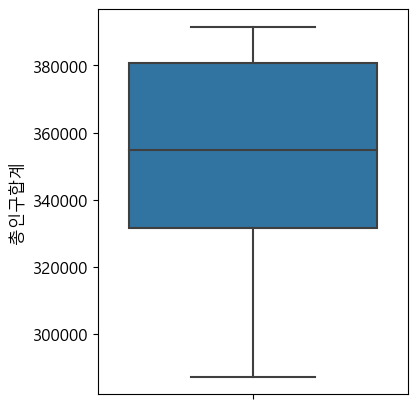

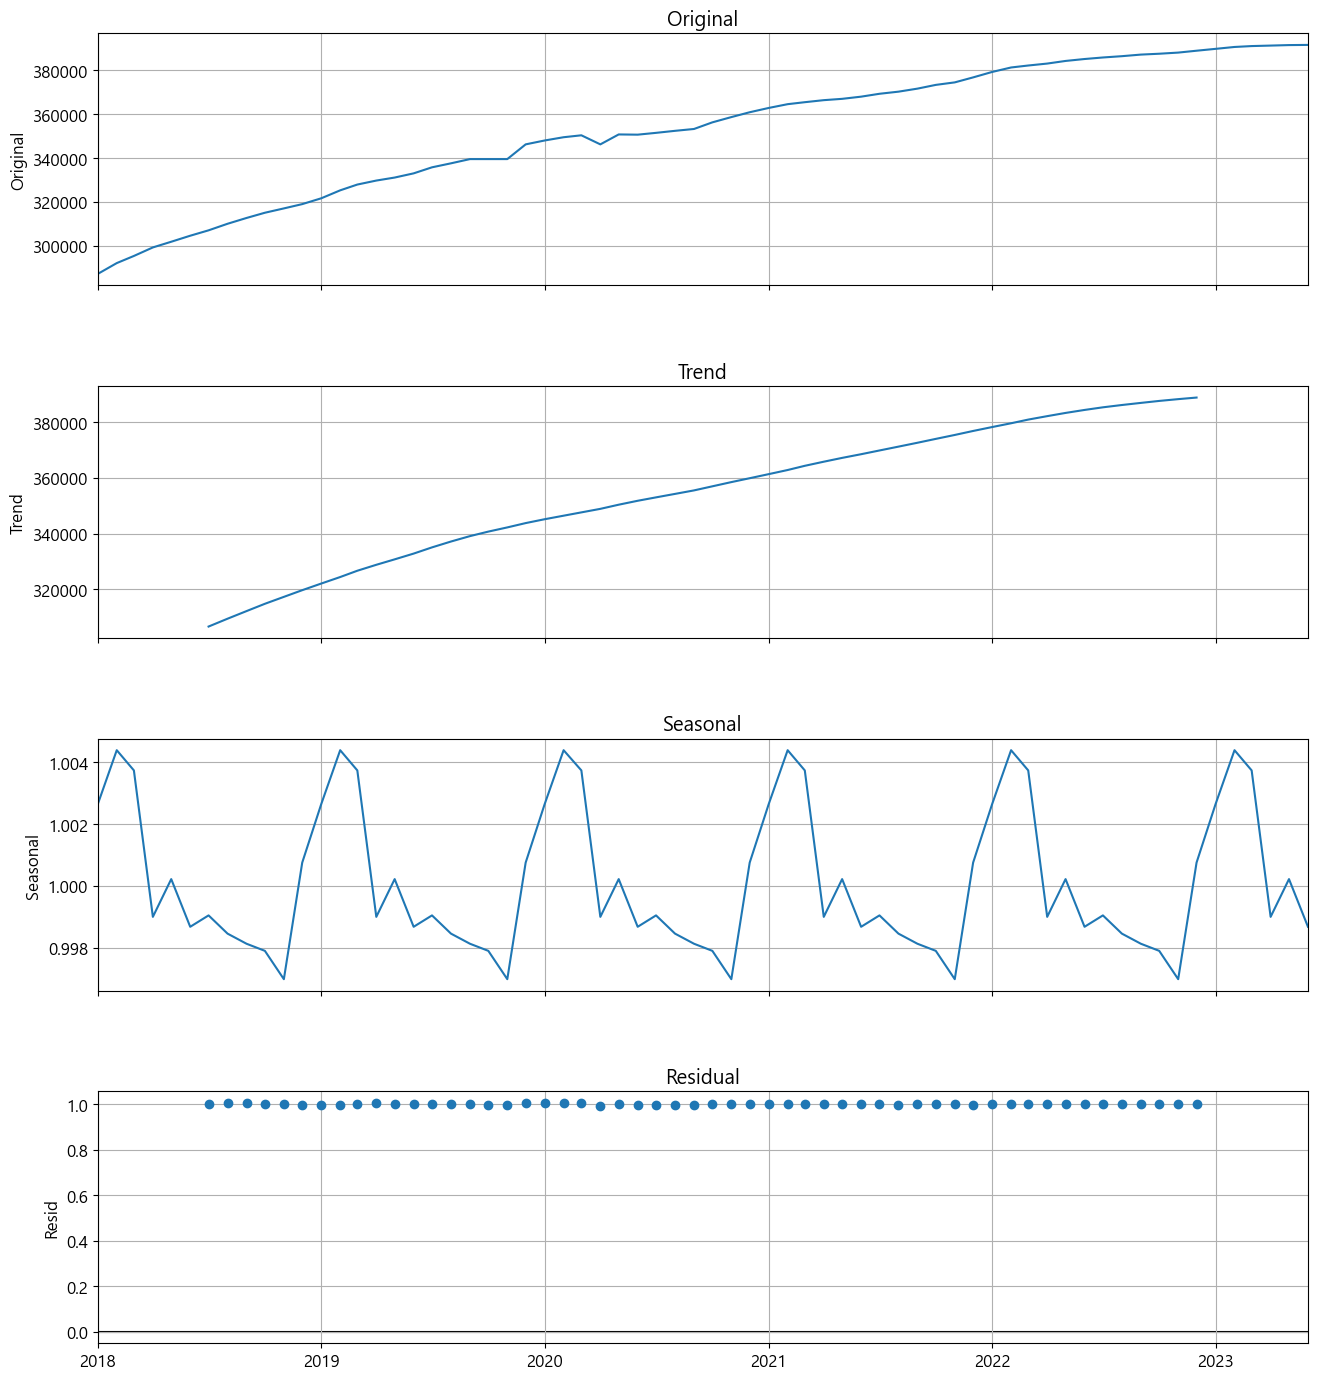

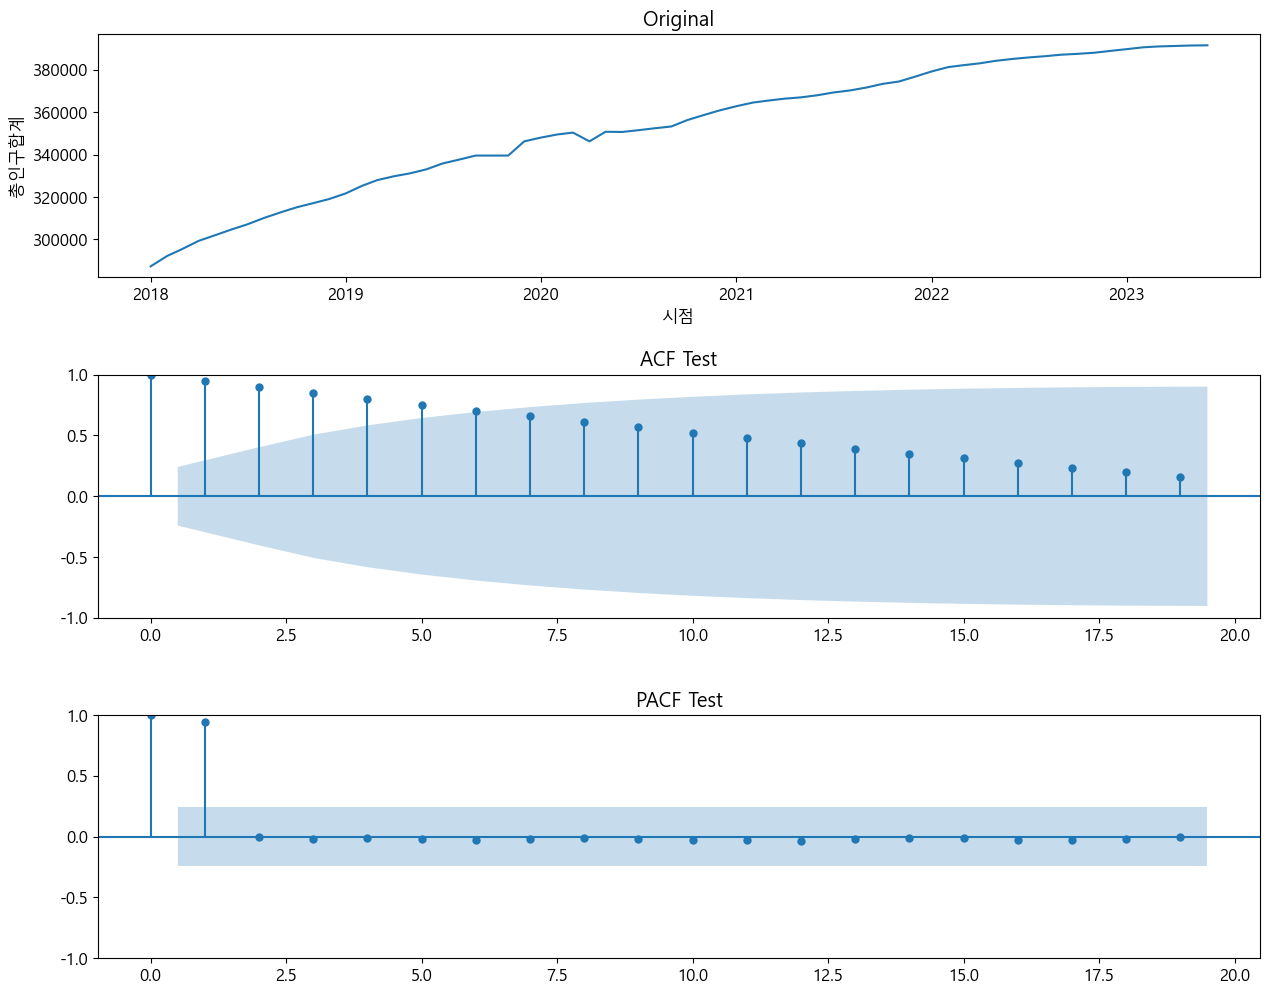

=========== 원본 데이터 ===========
+------------------------------------+------------+
| ADF Test                           |            |
|------------------------------------+------------|
| 검정통계량(ADF Statistic)          |   -3.47448 |
| 유의수준(p-value)                  | 0.00866716 |
| 최적차수(num of lags)              |          8 |
| 관측치 개수(num of observations)   |         57 |
| 기각값(Critical Values) 1%         |   -3.55067 |
| 기각값(Critical Values) 5%         |   -2.91377 |
| 기각값(Critical Values) 10%        |   -2.59462 |
| 데이터 정상성 여부(0=Flase,1=True) |          1 |
+------------------------------------+------------+


In [21]:
exp_time_data(data=df1,yname="총인구합계",sd_model='m',max_diff=5)

In [22]:
#auto arima 모델 이용하여 시계열 분석 진행

my_p = 1    # AR의 차수 (검증한 결과를 활용)
my_d = 0    # 차분 횟수 (검증한 결과를 활용)
my_q = 0    # MA의 차수 (검증한 결과를 활용)
my_s = 12    # 계절성 주기 (분석가가 판단) #1년에 4분기(12/4)로 진행해서 수치는 3으로,(데이터 자체도 3개월주기)

model = auto_arima(
    y=df1['총인구합계'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=my_q,          # q의 최대값
    seasonal=True,       # 계절성 사용 여부
    m=my_s,              # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1550.530, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1241.104, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1875.938, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1244.213, Time=0.06 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1552.443, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(1,0,0)(1,0,0)[12] intercept
Total fit time: 0.573 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   66
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -616.552
Date:                            Sun, 15 Oct 2023   AIC                           1241.104
Time:                                    18:11:25   BIC                           1249.862
Sample:                    

In [23]:
fv = model.fittedvalues()
fv.head()

시점
2018-01-01    349272.975457
2018-02-01    289185.897265
2018-03-01    293856.204167
2018-04-01    296925.675879
2018-05-01    300599.136451
dtype: float64

In [24]:
fc = model.predict(n_periods=12)
fc.head()

2023-07-01    390370.011806
2023-08-01    389198.896147
2023-09-01    388121.298821
2023-10-01    387007.832914
2023-11-01    385980.903479
Freq: MS, dtype: float64

In [25]:
last1 = df1.index.min()
last = df1.index.max()
xmin = last1
xmax = last+timedelta(days=365+123)
ymax = df1['총인구합계'][xmin:xmax].max()
xmin, xmax, ymax

(Timestamp('2018-01-01 00:00:00'), Timestamp('2024-10-01 00:00:00'), 391571)

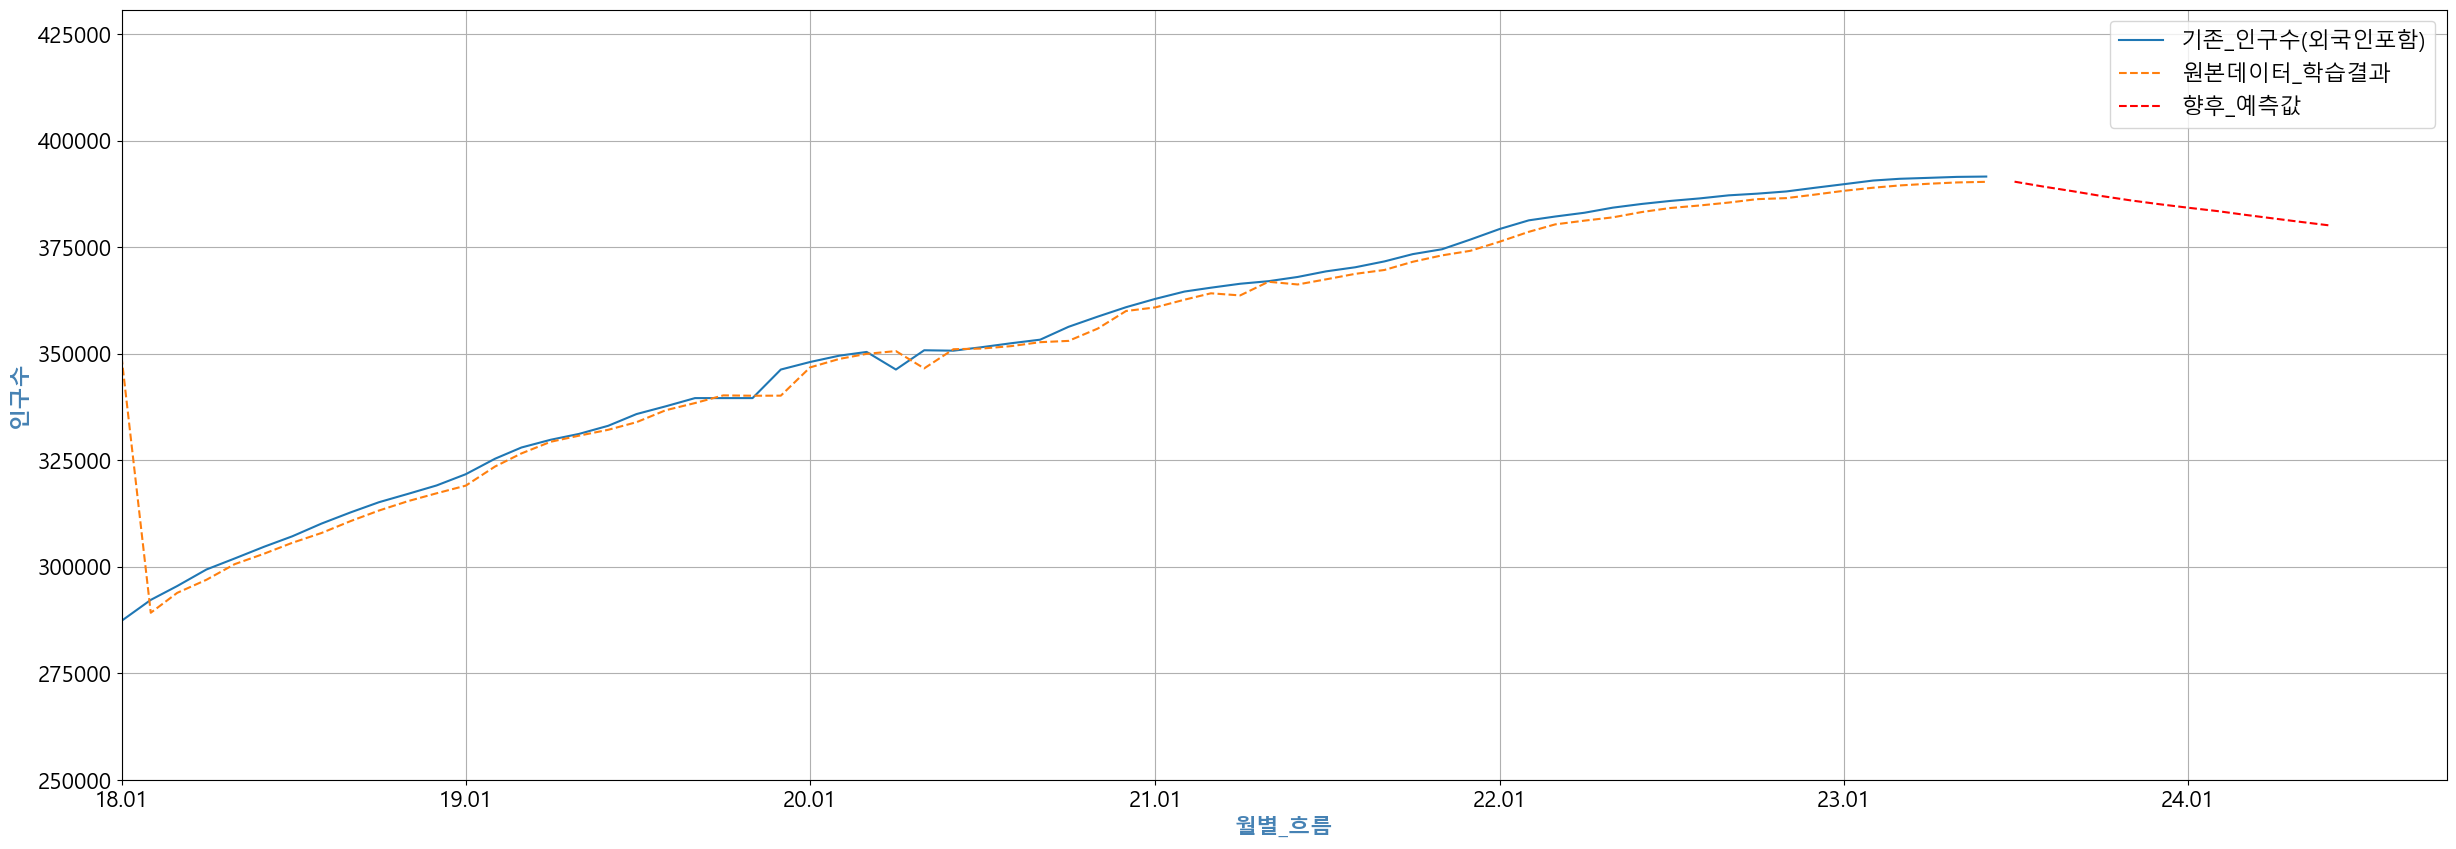

In [26]:
plt.rcParams["font.size"] = 16

plt.figure(figsize=(30,10))

# 원본 데이터
sb.lineplot(data=df1, x=df1.index, y='총인구합계', label='기존_인구수(외국인포함)')

# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='원본데이터_학습결과', linestyle='--')

# 향후 2년간의 예측값
sb.lineplot(x=fc.index, y=fc.values, label='향후_예측값', linestyle='--', color='red')

plt.xlabel('월별_흐름',color='steelblue',fontweight='bold')
plt.ylabel('인구수',color='steelblue',fontweight='bold')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([250000, ymax*1.1])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

시계열 그래프로 예측 결과 데이터의 처음 시작 일자인 18년도부터 22년까지는 지속적인 인구 성장이 확인되었다.

그러나 그 이후부터 인구 성장세가 소폭으로 올라가고 23년도부터 인구 성장이 거의 멈춘것으로 보여진다

향후 예측으로는 특별한 이슈가 없는 이상 인구 감소세로 들어서는 것으로 보여진다.

다만 해당 예측값보다는 보수적으로 판단시 소폭으로 감소할것으로 보여진다.

<관련기사>

https://n.news.naver.com/mnews/article/014/0005064766?sid=101

https://www.sjsori.com/news/articleView.html?idxno=65111

https://www.hani.co.kr/arti/area/chungcheong/1103229.html
